# Sketch Classifier for "How Do Humans Sketch Objects?"

A sketch classifier using the dataset from the paper <a href='http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/'>How Do Humans Sketch Objects?</a> where the authors collected 20,000 unique sketches evenly distributed over 250 object categories - we will use a CNN (using Keras) to classify a sketch. 

<img src='http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/teaser_siggraph.jpg'/>

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
import os
import random

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')

In [20]:
SKETCH_DIR = '/Volumes/Storage/sketches/png/'
DEST_SKETCH_DIR = '/Volumes/Storage/sketches/sketches_training_data/'
TARGET_SIZE = (128,128)

In [4]:
def get_image_file_paths_and_categories():
    """
    Walk the root directory and for each subdirectory, obtain the 
    list of .png image files creating (and returning) a list for each category label and 
    associated filepath 
    """
    image_file_paths = [] 
    categories = [] 
    for d in os.listdir(SKETCH_DIR):
        label = d 

        if not os.path.isdir(os.path.join(SKETCH_DIR, d)):
            continue 
            
        for f in os.listdir(os.path.join(SKETCH_DIR, d)):
            full_path = os.path.join(os.path.join(SKETCH_DIR, d), f)            
            if os.path.isfile(full_path) and ".png" in full_path.lower():
                categories.append(label)
                image_file_paths.append(full_path)
    return image_file_paths, categories

## Training and validation split 

To avoid loading all images into memory; we will load and unload them from disk - to make this task easier (and take advantage of the built in generators from Keras) we will split the data into different directories for training and validation and take this opportunity for so preprocessing; in this case simply reducing the size from 1111x1111 to 128x128.  

In [5]:
def split_training_validation_data(shuffle=True, split=0.8, target_size=TARGET_SIZE):
    """
    Split the data into training and validation (as well as resizing the images) 
    Copies are made from the main file path and stored in a destination folder. 
    """
    
    image_scale = None
    training_samples_count = 0 
    validation_samples_count = 0 
    
    for d in os.listdir(SKETCH_DIR):
        label = d 

        if not os.path.isdir(os.path.join(SKETCH_DIR, d)):
            continue 
            
        file_names = []
        file_data = []
            
        for f in os.listdir(os.path.join(SKETCH_DIR, d)):
            full_path = os.path.join(os.path.join(SKETCH_DIR, d), f)            
            if os.path.isfile(full_path) and ".png" in full_path.lower():
                file_names.append(f)
                if image_scale is None:
                    image_scale = float(target_size[0]) / float(plt.imread(full_path).shape[0]) 
                file_data.append(imresize(plt.imread(full_path), image_scale))
                
        # shuffle 
        indexes = np.arange(len(file_names))
        if shuffle:
            np.random.shuffle(indexes)
        
        training_end_index = int(len(indexes) * split)
        training_indexes = indexes[:training_end_index]
        validation_indexes = indexes[training_end_index:]
            
        training_dir = os.path.join(DEST_SKETCH_DIR, 'training')
        validation_dir = os.path.join(DEST_SKETCH_DIR, 'validation')
            
        class_training_dir = os.path.join(training_dir, label)
        class_validation_dir = os.path.join(validation_dir, label)
            
        if not os.path.exists(training_dir):
            os.mkdir(training_dir)
                
        if not os.path.exists(validation_dir):
            os.mkdir(validation_dir)
                
        if not os.path.exists(class_training_dir):
            os.mkdir(class_training_dir)
                
        if not os.path.exists(class_validation_dir):
            os.mkdir(class_validation_dir)
                
        for idx in training_indexes:
            training_samples_count += 1            
            plt.imsave(
                os.path.join(class_training_dir, file_names[idx]), file_data[idx], 
                format='png', cmap='gray')
            
        for idx in validation_indexes:
            validation_samples_count += 1
            plt.imsave(
                os.path.join(class_validation_dir, file_names[idx]), file_data[idx], 
                format='png', cmap='gray')
            
    print("Finished - training samples = {}, validation samples {}".format(training_samples_count, 
                                                                           validation_samples_count))
    
    return training_samples_count, validation_samples_count

In [ ]:
training_samples_count, validation_samples_count = split_training_validation_data()

## Inspecting our data 

Let's do a little exploration to get a better feel for the data; starting simply with how many examples we have and how many classes.  

In [8]:
print("training_samples_count {}, validation_samples_count {}".format(
    training_samples_count, validation_samples_count))

training_samples_count 16000, validation_samples_count 4000


In [112]:
image_file_paths, image_categories = get_image_file_paths_and_categories()

In [113]:
print("Total number of classes {}".format(len(set(image_categories))))

Total number of classes 250


In [114]:
print("Total number of training examples {}".format(len(image_categories)))

Total number of training examples 20000


Let's visualise some of the examples to see what we're dealing with. 

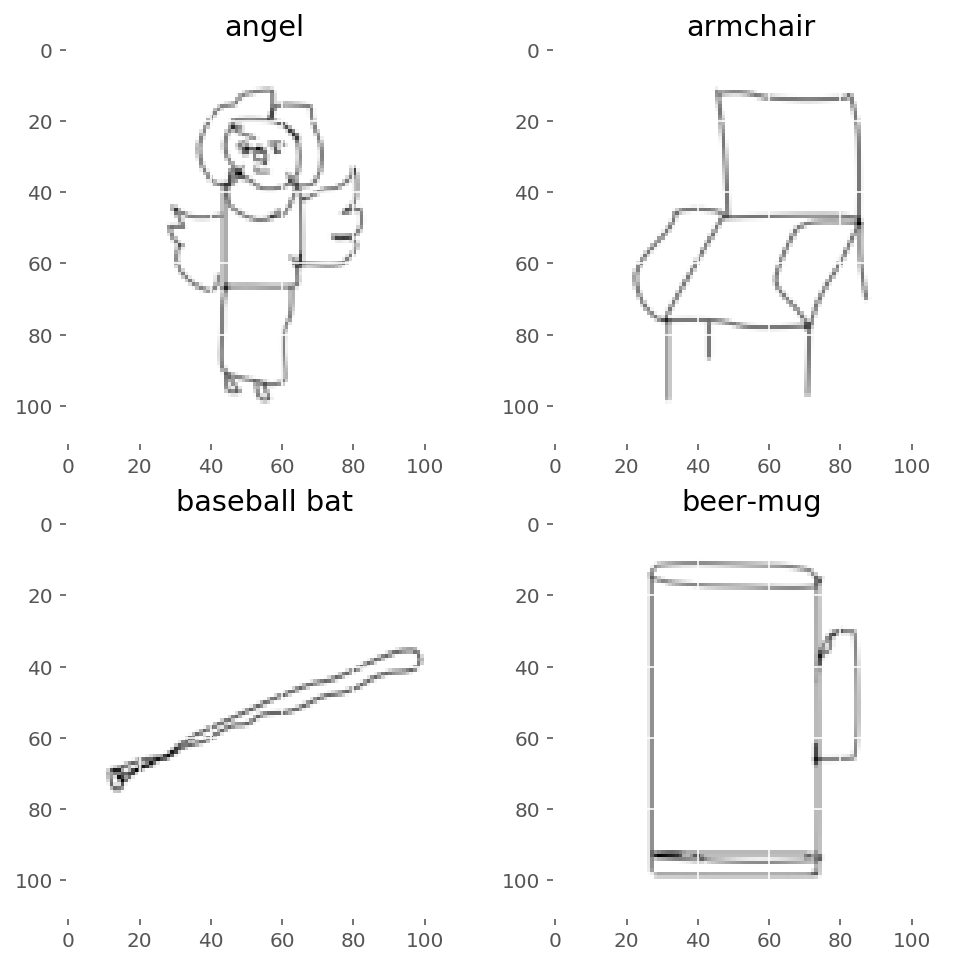

In [116]:
f, axarr = plt.subplots(2, 2, figsize=(8,8))
axarr[0, 0].imshow(imresize(plt.imread(image_file_paths[200]), 0.1), cmap='gray', interpolation='nearest')
axarr[0, 0].set_title(image_categories[200])
axarr[0, 1].imshow(imresize(plt.imread(image_file_paths[500]), 0.1), cmap='gray', interpolation='nearest')
axarr[0, 1].set_title(image_categories[500])
axarr[1, 0].imshow(imresize(plt.imread(image_file_paths[1000]), 0.1), cmap='gray', interpolation='nearest')
axarr[1, 0].set_title(image_categories[1000])
axarr[1, 1].imshow(imresize(plt.imread(image_file_paths[1500]), 0.1), cmap='gray', interpolation='nearest')
axarr[1, 1].set_title(image_categories[1500])

## Create model and Train

Time to create the model and train on our data. 

In [7]:
import keras 
keras.__version__

'2.0.8'

In [8]:
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks

from keras.utils import plot_model

from keras import preprocessing
from keras.preprocessing import image

In [9]:
def plot_accuracy_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

--- 

Inutitive we can see that, unlike photos, sketches don't have mine details but are better described by their strokes. This is how I had previously tackled the problem; using <a href='https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients'>Histogram of oriented gradients (HOG)</a> filters, I built a bag of visual words for each image. These 'visual words' were dominate gradients of each patch. We can replicate something similar using a ConvNet, but unlike my previous attempt, the feature engineering will be defined and refined during training using the lower layers of the network.  

In [11]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(16, (7,7), padding='same', activation='relu', input_shape=input_shape, 
                            name='input_convnet_1_16_7x7'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu', name='convnet_2_32_5x5'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', name='convnet_3_64_3x3'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(1024, activation='relu', name='dense_1_1024'))
    model.add(layers.Dense(512, activation='relu', name='dense_2_512'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

--- 

More data always proves to be useful; exposing the network to more samples means that the model has a better chance of identifying and extracting the features that best *describe* a category. Images provide has an advantage over text in that we can easily modify it to expose the network to more samples, such as shifting the image around, rotating and flipping. This task is called *data augmentation* and Keras makes it easy, as shown below. For more information, check out the official Keras <a href='https://keras.io/preprocessing/image/'>documentation</a>.   

In [10]:
def train(model, 
          training_dir,
          validation_dir,
          target_size=(128,128), 
          training_samples=16000, 
          validation_samples=4000,
          epochs=15, 
          batch_size=32, 
          validation_split=0.2, 
          load_previous_weights=True,
          model_weights_file=None):
    """
    
    """
    
    if model_weights_file is None:
        raise("No model weights file set")
    
    print("Training STARTED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    if model_weights_file is not None and os.path.isfile(model_weights_file) and load_previous_weights:
        print("Loading weights from file {}".format(model_weights_file))
        model.load_weights(model_weights_file)

    model.compile(
        loss='categorical_crossentropy', 
        optimizer='rmsprop', 
        metrics=['accuracy'])
    
    # create data generator     
    # check the official documentation for more details: https://keras.io/preprocessing/image/
    datagen = preprocessing.image.ImageDataGenerator(
        rescale=1./255., # rescaling factor applied by multiply the data by this value  
        rotation_range=20, # value in degrees (0-180), a range within which to randomly rotate pictures
        width_shift_range=0.1, # ranges (as a fraction of total width) to randomly translate pictures 
        height_shift_range=0.1, # ranges (as a fraction of total height) to randomly translate pictures 
        shear_range=0.1, # randomly applying shearing transformations
        zoom_range=0.1, # randomly zooming inside pictures
        horizontal_flip=True, # randomly flipping half of the images horizontally
        fill_mode='nearest') # strategy used for filling in newly created pixels
    
    if model.layers[0].input_shape[0] == target_size[0] and model.layers[0].input_shape[1] == target_size[1]:
        target_size = None
    
    # create an iterator for the training data 
    train_generator = datagen.flow_from_directory(
        training_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    # create an iterator for the validation data 
    validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    checkpoint = callbacks.ModelCheckpoint(model_weights_file, 
                                           monitor='val_loss', 
                                           verbose=0, 
                                           save_best_only=True, 
                                           save_weights_only=True, 
                                           mode='auto', 
                                           period=2)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    data_augmentation_multiplier = 1.2 
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=int((training_samples/batch_size) * data_augmentation_multiplier),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int((validation_samples/batch_size) * data_augmentation_multiplier), 
        callbacks=[checkpoint, early_stopping]) 
    
    print("Training FINISHED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    return history, model     

Training STARTED - target size (128, 128), batch size 512
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
37/37 [==============================] - 43s - loss: 5.5626 - acc: 0.0033 - val_loss: 5.5214 - val_acc: 0.0035
Epoch 2/1000
37/37 [==============================] - 35s - loss: 5.5219 - acc: 0.0028 - val_loss: 5.5215 - val_acc: 0.0049
Epoch 3/1000
37/37 [==============================] - 34s - loss: 5.5233 - acc: 0.0035 - val_loss: 5.5215 - val_acc: 0.0035
Epoch 4/1000
37/37 [==============================] - 33s - loss: 5.5228 - acc: 0.0027 - val_loss: 5.5214 - val_acc: 0.0040
Epoch 5/1000
37/37 [==============================] - 34s - loss: 5.5220 - acc: 0.0026 - val_loss: 5.5215 - val_acc: 0.0044
Epoch 6/1000
37/37 [==============================] - 34s - loss: 5.5245 - acc: 0.0037 - val_loss: 5.5207 - val_acc: 0.0029
Epoch 7/1000
37/37 [==============================] - 34s - loss: 5.4507 - acc: 0.0090 - val_loss: 5.2201 - v

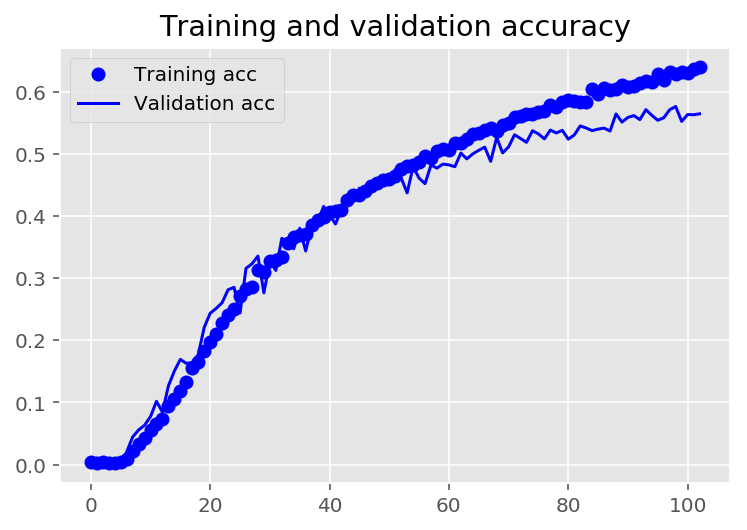

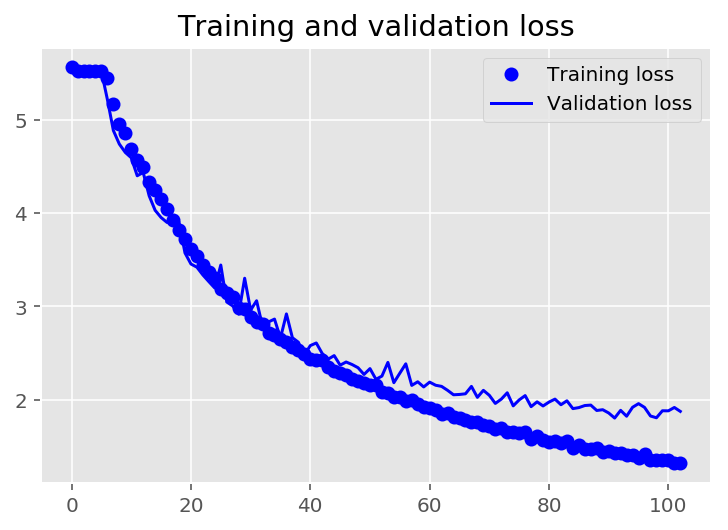

In [39]:
history, model = train(create_model(input_shape=(128,128,1)), 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=512,
                       model_weights_file="output/cnn_sketch_weights_24.h5", 
                       load_previous_weights=True)

plot_accuracy_loss(history)

<img src='training_validation_accuracy.png' width='400px' />
<img src='training_validation_loss.png' width='400px' />

--- 

## Evaluate model

Time for some manual inspection; let's throw some images at it and see how our model performs. 

In [156]:
model = create_model(is_training=False)
model.load_weights("output/cnn_sketch_weights_rc_1.h5")

In [157]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_convnet_1_16_7x7 (Conv (None, 128, 128, 16)      800       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
convnet_2_32_5x5 (Conv2D)    (None, 64, 64, 32)        12832     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
convnet_3_64_3x3 (Conv2D)    (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)             0         
__________

In [ ]:
plot_model(model, to_file='model.png')

<img src='model.png' width='200px'/>

In [5]:
def get_validation_metadata():
    """
    Walk the root directory and for each subdirectory, obtain the 
    list of .png image files creating (and returning) a list for each category label and 
    associated filepath 
    """
    image_file_paths = [] 
    categories = [] 
    labels = []    
    
    validation_dirs = sorted(os.listdir(os.path.join(DEST_SKETCH_DIR, 'validation')))
    for d in validation_dirs:                 
        
        if not os.path.isdir(os.path.join(validation_dir, d)):
            continue 
            
        labels.append(d) 
        label = d
            
        for f in os.listdir(os.path.join(validation_dir, d)):
            full_path = os.path.join(os.path.join(validation_dir, d), f)            
            if os.path.isfile(full_path) and ".png" in full_path.lower():
                categories.append(label)
                image_file_paths.append(full_path)
    return labels, image_file_paths, categories

In [6]:
def make_predictions(model, categories, filepaths, labels, sample_idx, target_dimension=128.0):
    filename = filepaths[sample_idx]
    
    img = plt.imread(filename) # load image 
    
    scale = 1.0 
    # resize if size doesn't match the target dimension (assuming image is square)
    if img.shape[0] != target_dimension:
        scale = target_dimension / img.shape[0]
        img = imresize(img, scale)
        
    img = img[:,:,0] # take the single channel 
    img = img.reshape(1, int(target_dimension), int(target_dimension), 1)
    
    probs = model.predict(img)[0]
    predicted_index = np.argmax(probs)
    
    plt.imshow(imresize(plt.imread(filename), scale), 
               cmap='gray', 
               interpolation='nearest')
    
    plt.title("Pred: {} ({}%), Actual: {}".format(
        categories[predicted_index], 
        int(probs[predicted_index]*100),
        labels[sample_idx]))
    plt.tight_layout()
    plt.show() 
    
    return predicted_index

In [7]:
categories, validation_filepaths, labels = get_validation_metadata()

NameError: global name 'DEST_SKETCH_DIR' is not defined

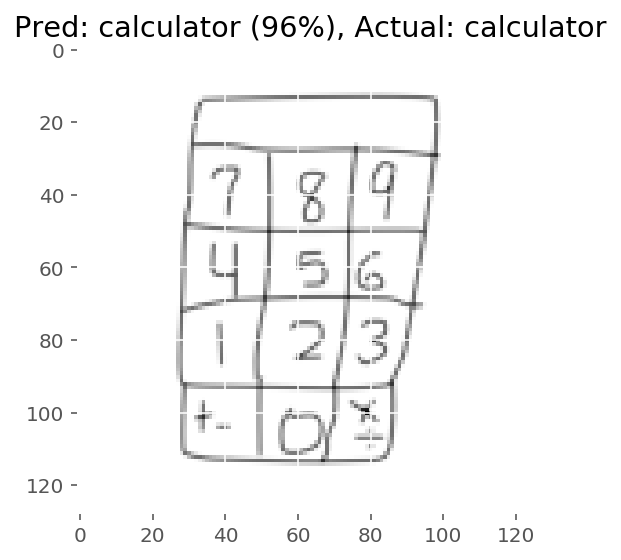

In [23]:
_ = make_predictions(model,
                     categories,
                     validation_filepaths, 
                     labels, 
                     random.randint(0,len(validation_filepaths) - 1))

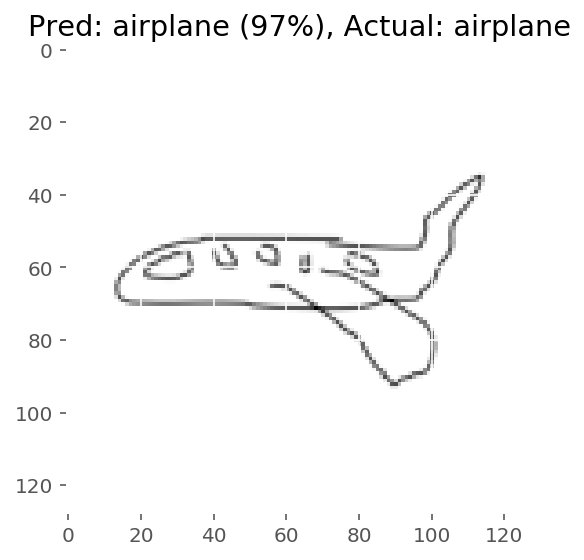

In [24]:
_ = make_predictions(model,
                     categories,
                     validation_filepaths, 
                     labels, 
                     0)

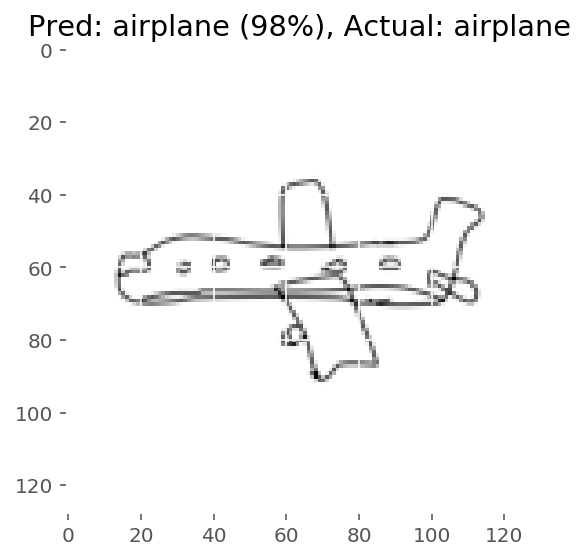

In [25]:
_ = make_predictions(model,
                     categories,
                     validation_filepaths, 
                     labels, 
                     10)

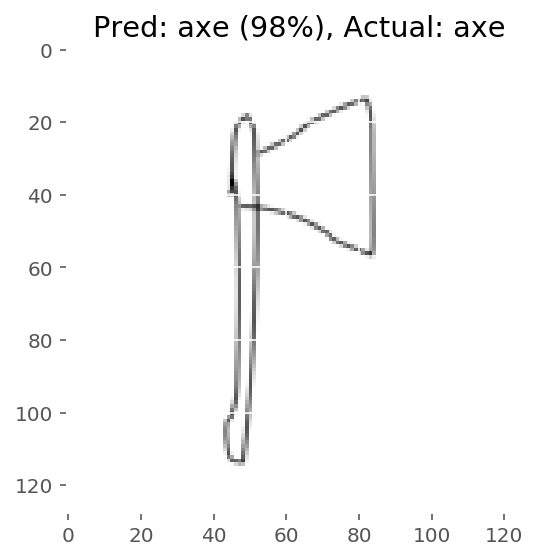

In [26]:
_ = make_predictions(model,
                     categories,
                     validation_filepaths, 
                     labels, 
                     150)

### Confusion matrix 

One way to evaluate the quality of your classifier (especially for multi-class) is visualising a confusion matrix. The diagonal elements represent the number of point for which the predicted label is equal to the true label, while the off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix, the better the model is performing i.e. we should see a dark line diagonally along the plot. 

In [194]:
def plot_confusion_matrix(model, categories, filepaths, labels, 
                          target_dimension=128.0, normalize=False, cmap=plt.cm.Blues):
    from sklearn.metrics import confusion_matrix
    
    y_true = [] 
    y_pred = [] 
    
    category_2_idx = {category:idx for idx, category in enumerate(categories)}
    idx_2_category = {idx:category for idx, category in enumerate(categories)}
    
    for idx, filename in enumerate(filepaths): 
        img = plt.imread(filename) # load image 
    
        scale = 1.0 
        # resize if size doesn't match the target dimension (assuming image is square)
        if img.shape[0] != target_dimension:
            scale = target_dimension / img.shape[0]
            img = imresize(img, scale)
        
        img = img[:,:,0] # take the single channel 
        img = img.reshape(1, int(target_dimension), int(target_dimension), 1)
    
        probs = model.predict(img)[0]
        predicted_index = np.argmax(probs)        
        actual_index = category_2_idx[labels[idx]] 
        
        y_true.append(labels[idx])
        y_pred.append(idx_2_category[predicted_index])
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
        
    cnf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=categories)
    
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 12))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    #tick_marks = np.arange(len(categories))
    #plt.xticks(tick_marks, categories, rotation=45)
    #plt.yticks(tick_marks, categories)
    #plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

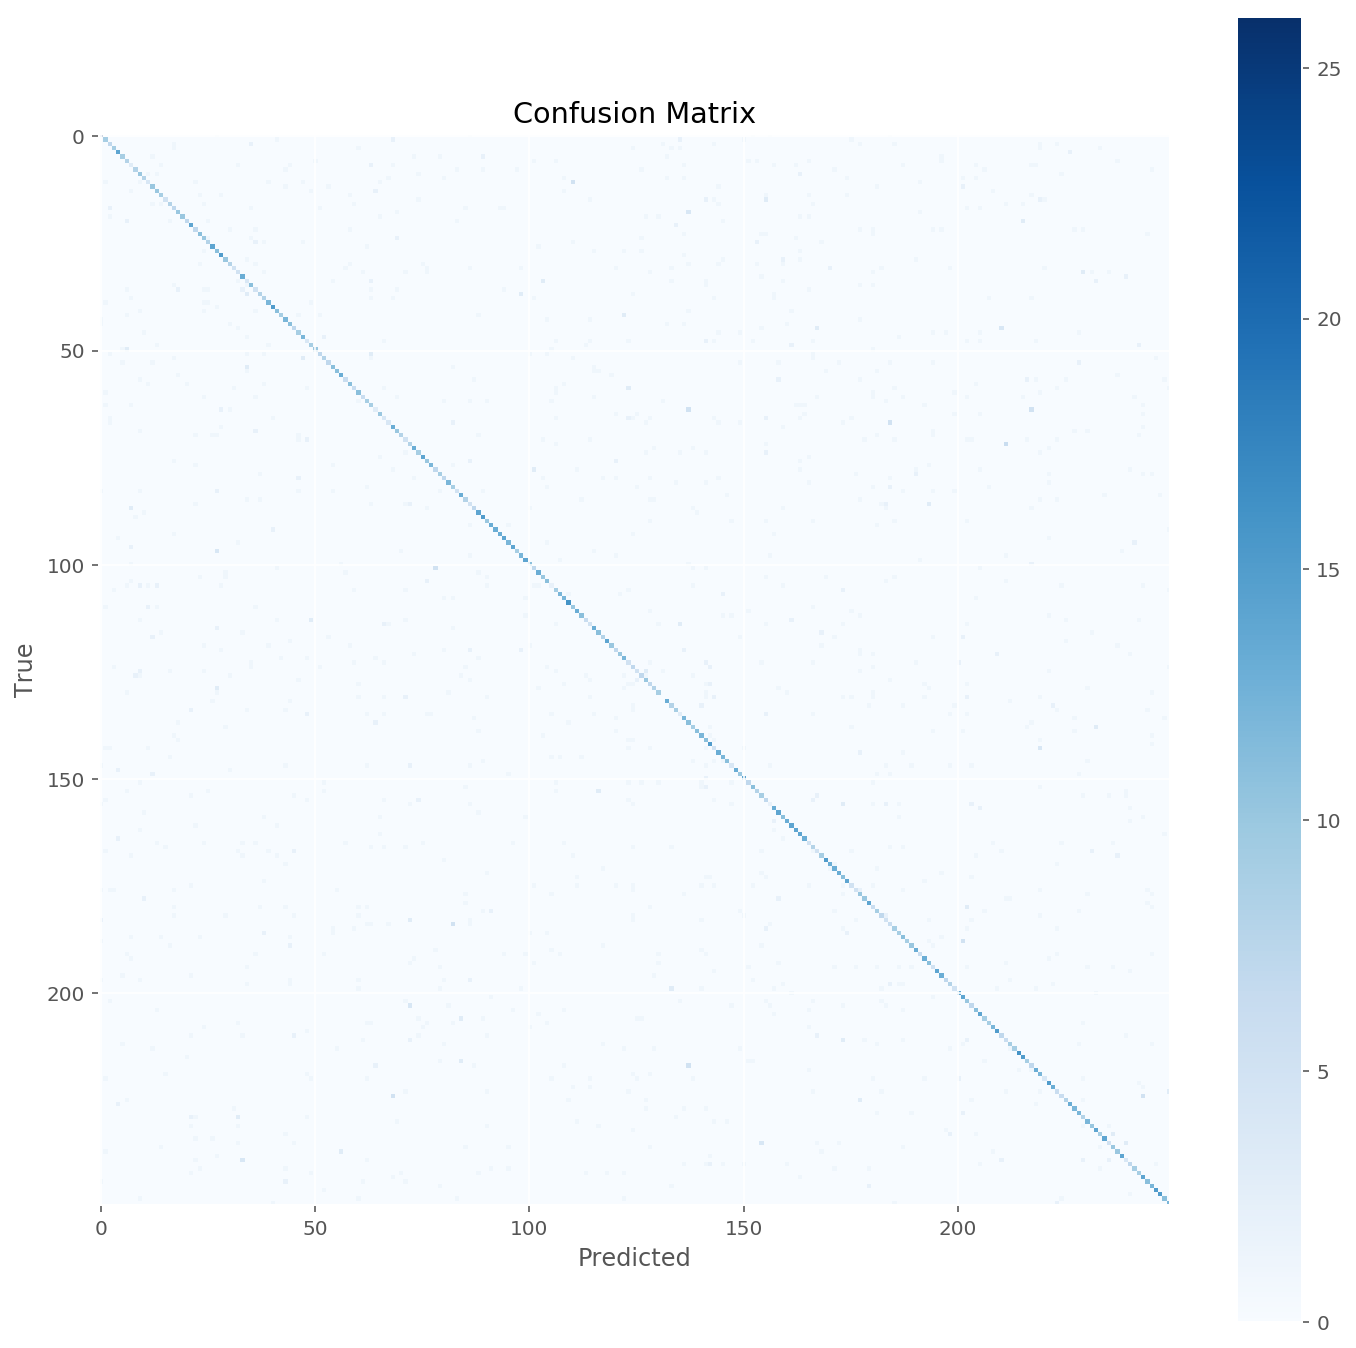

In [195]:
plot_confusion_matrix(model, 
                      categories, 
                      validation_filepaths, 
                      labels)

## Create CoreML model 

In [158]:
import coremltools

In [162]:
coreml_model = coremltools.converters.keras.convert(model, 
                                                    input_names=['image'], 
                                                    image_input_names=['image'], 
                                                    output_names=['classLabelProbs'],
                                                    class_labels=categories)

0 : input_convnet_1_16_7x7_input, <keras.engine.topology.InputLayer object at 0x120215a10>
1 : input_convnet_1_16_7x7, <keras.layers.convolutional.Conv2D object at 0x1202c4550>
2 : input_convnet_1_16_7x7__activation__, <keras.layers.core.Activation object at 0x11db62fd0>
3 : max_pooling2d_7, <keras.layers.pooling.MaxPooling2D object at 0x1203f7a90>
4 : convnet_2_32_5x5, <keras.layers.convolutional.Conv2D object at 0x1202a58d0>
5 : convnet_2_32_5x5__activation__, <keras.layers.core.Activation object at 0x1366b3690>
6 : max_pooling2d_8, <keras.layers.pooling.MaxPooling2D object at 0x1202a5850>
7 : convnet_3_64_3x3, <keras.layers.convolutional.Conv2D object at 0x1218c8290>
8 : convnet_3_64_3x3__activation__, <keras.layers.core.Activation object at 0x1366b3310>
9 : max_pooling2d_9, <keras.layers.pooling.MaxPooling2D object at 0x1219f9e90>
10 : flatten_3, <keras.layers.core.Flatten object at 0x1321a5390>
11 : dense_1_1024, <keras.layers.core.Dense object at 0x132202a50>
12 : dense_1_1024__a

In [198]:
def test_coreml(coreml_model, 
                         categories, 
                         filepaths, 
                         labels, 
                         sample_idx, 
                         target_dimension=128):
    
    from PIL import Image  
    
    filename = filepaths[sample_idx]
    
    # load image
    img = Image.open(filename).convert('L')  
    
    # resize if size doesn't match the target dimension (assuming image is square)    
    scale = 1.0 
    if img.size[0] != target_dimension:
        scale = target_dimension / img.size[0]
        img = imresize(img, scale)
    
    results = coreml_model.predict({'image':img})
    predicted_label = results['classLabel']
    predicted_prob = results['classLabelProbs'][predicted_label]
    
    true_label = labels[sample_idx]
    
    plt.imshow(imresize(plt.imread(filename), scale), 
               cmap='gray', 
               interpolation='nearest')    
    
    plt.title("Pred: {} ({}%), Actual: {}".format(
        predicted_label, 
        int(predicted_prob*100),
        true_label))
    plt.tight_layout()
    plt.show() 
    

L


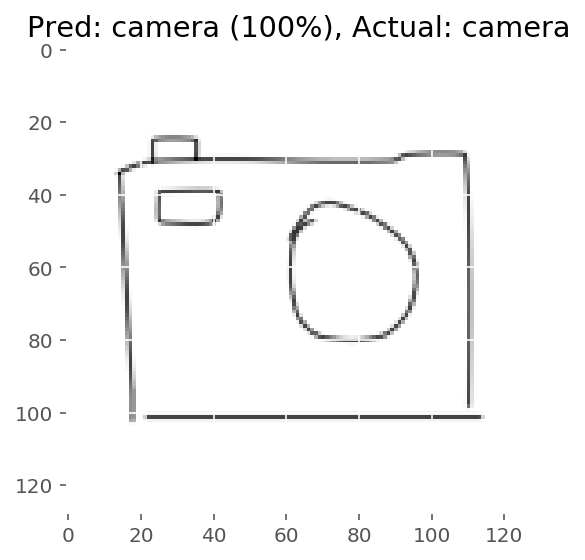

In [197]:
test_coreml(coreml_model, 
            categories,
            validation_filepaths, 
            labels, 
            random.randint(0, len(validation_filepaths)-1))

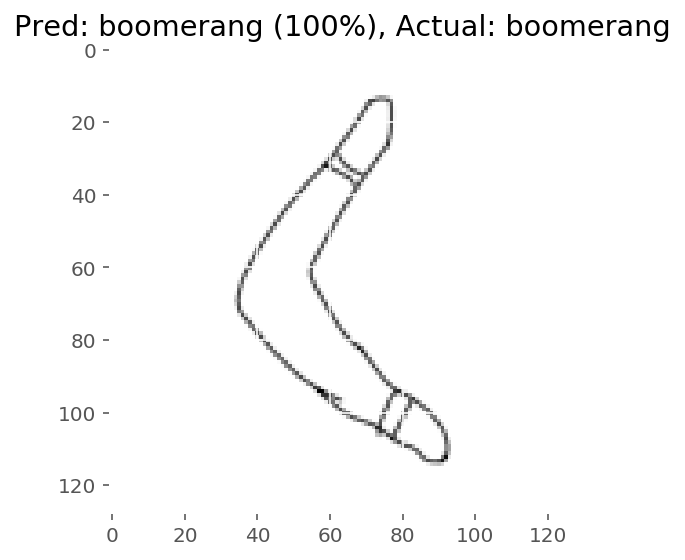

In [200]:
test_coreml(coreml_model, 
            categories,
            validation_filepaths, 
            labels, 
            random.randint(0, len(validation_filepaths)-1))

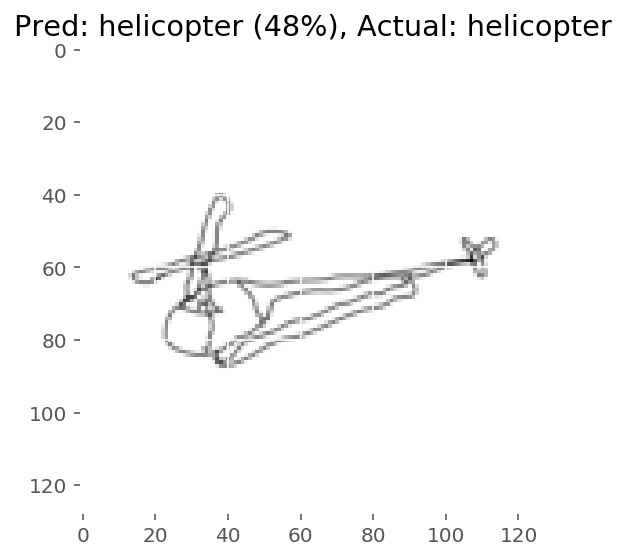

In [47]:
test_coreml(coreml_model, 
            categories,
            validation_filepaths, 
            labels, 
            random.randint(0, len(validation_filepaths)-1))

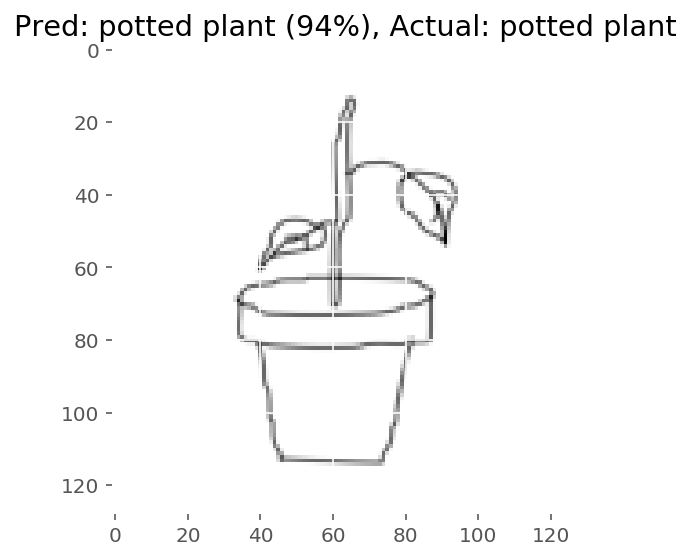

In [48]:
test_coreml(coreml_model, 
            categories,
            validation_filepaths, 
            labels, 
            random.randint(0, len(validation_filepaths)-1))

### CoreML model metadata

In [201]:
coreml_model.author = 'Joshua Newnham'
coreml_model.license = 'BSD'
coreml_model.short_description = 'Freehand sketch recognizer trained using the dataset from the paper How Do Humans Sketch Objects? consisting of 250 categories using a total of 20k examples'
coreml_model.input_description['image'] = 'Input sketch (grayscale image) to be classified'
coreml_model.output_description['classLabelProbs'] = 'Probability of each category'
coreml_model.output_description['classLabel'] = 'Most likely sketch category'

### Save CoreML model and labels

In [202]:
coreml_model.save('output/cnnsketchclassifier.mlmodel')

In [52]:
with open('output/sketch_classes.csv', 'w') as f:
    for idx, category in enumerate(categories):
        f.write("{},{}\n".format(idx, category))

# Visual Similarity

Previously we created a model to classify a given sketch; in this part we want to make use of this model to find similar images - how? Currently our model outputs a probability distribution across the 250 classes (we take the max probability as the predicted class) but we can also use this model to find similar images simply by inspecting and comparing the activations of the higher layers; either taking the layer above the output or layer above this. Let's but this idea to practice.  

In [203]:
model = create_model(is_training=False)
model.load_weights("output/cnn_sketch_weights_rc_1.h5")

In [204]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_convnet_1_16_7x7 (Conv (None, 128, 128, 16)      800       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
convnet_2_32_5x5 (Conv2D)    (None, 64, 64, 32)        12832     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
convnet_3_64_3x3 (Conv2D)    (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)             0         
__________

In [205]:
model.layers.pop()

**Remove last layer** 

In [206]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_convnet_1_16_7x7 (Conv (None, 128, 128, 16)      800       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
convnet_2_32_5x5 (Conv2D)    (None, 64, 64, 32)        12832     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
convnet_3_64_3x3 (Conv2D)    (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)             0         
__________

We next have to create a model; updating it's input and outputs to reflect the changes above i.e. assigning our last layer (above) as the output of our model. 

In [207]:
from keras.models import Model

model_input = model.input
model_output = model.layers[-1].output

model = Model(model_input, model_output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_convnet_1_16_7x7_input (None, 128, 128, 1)       0         
_________________________________________________________________
input_convnet_1_16_7x7 (Conv (None, 128, 128, 16)      800       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
convnet_2_32_5x5 (Conv2D)    (None, 64, 64, 32)        12832     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
convnet_3_64_3x3 (Conv2D)    (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 64)        0         
__________

In [218]:
def get_activations(model, filename, flip=False, target_dimension=128.0):
    img = plt.imread(filename) # load image 
    
    scale = 1.0 
    # resize if size doesn't match the target dimension (assuming image is square)
    if img.shape[0] != target_dimension:
        scale = target_dimension / img.shape[0]
        img = imresize(img, scale)
        
    img = img[:,:,0] # take the single channel 
    img = img.reshape(1, int(target_dimension), int(target_dimension), 1)
    
    if flip:
        img = np.fliplr(img)
    
    probs = model.predict(img)[0]

    return probs 

In [215]:
def plot_image(categories, filepaths, labels, sample_idx, flip=False, target_dimension=128.0):
    filename = filepaths[sample_idx]
    
    img = plt.imread(filename) # load image 
    
    scale = 1.0 
    # resize if size doesn't match the target dimension (assuming image is square)
    if img.shape[0] != target_dimension:
        scale = target_dimension / img.shape[0]
        img = imresize(img, scale)
        
    img = img[:,:,0] # take the single channel 
    img = img.reshape(1, int(target_dimension), int(target_dimension), 1)
        
    plt.imshow(imresize(plt.imread(filename), scale), 
               cmap='gray', 
               interpolation='nearest')
    
    plt.title("{}".format(
        labels[sample_idx]))
    plt.tight_layout()
    plt.show() 

In [216]:
categories, validation_filepaths, labels = get_validation_metadata()

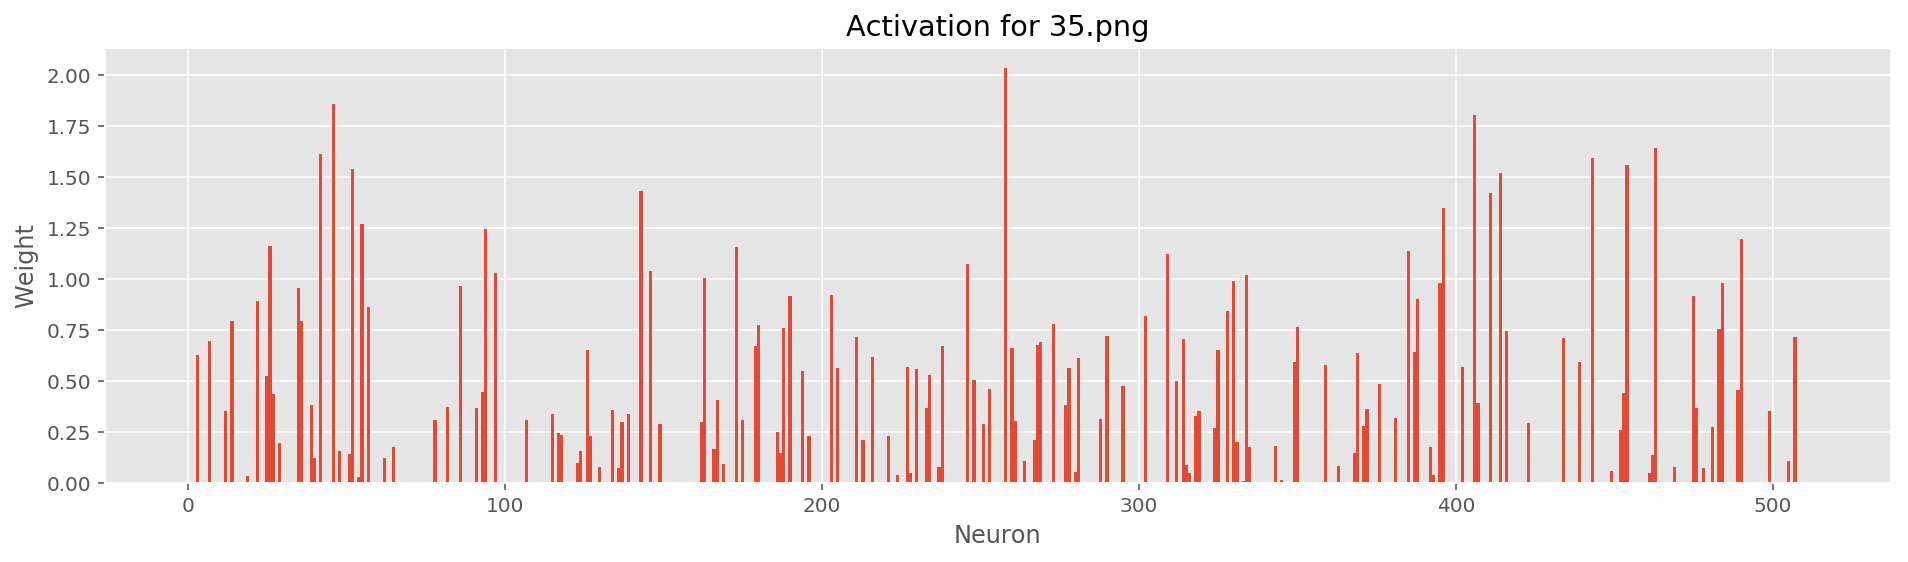

In [219]:
plt.figure(figsize=(16,4))
plt.bar(np.arange(512), get_activations(model, validation_filepaths[10]), width=1)
plt.title('Activation for {}'.format(
    os.path.split(validation_filepaths[10])[-1]))
plt.xlabel('Neuron')
plt.ylabel('Weight')

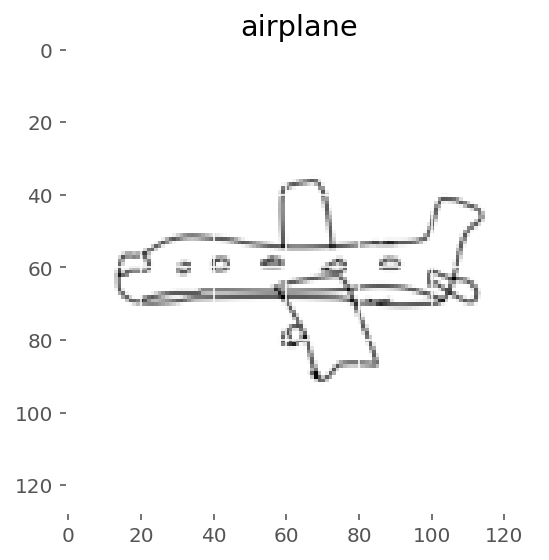

In [120]:
plot_image(categories, validation_filepaths, labels, 10)

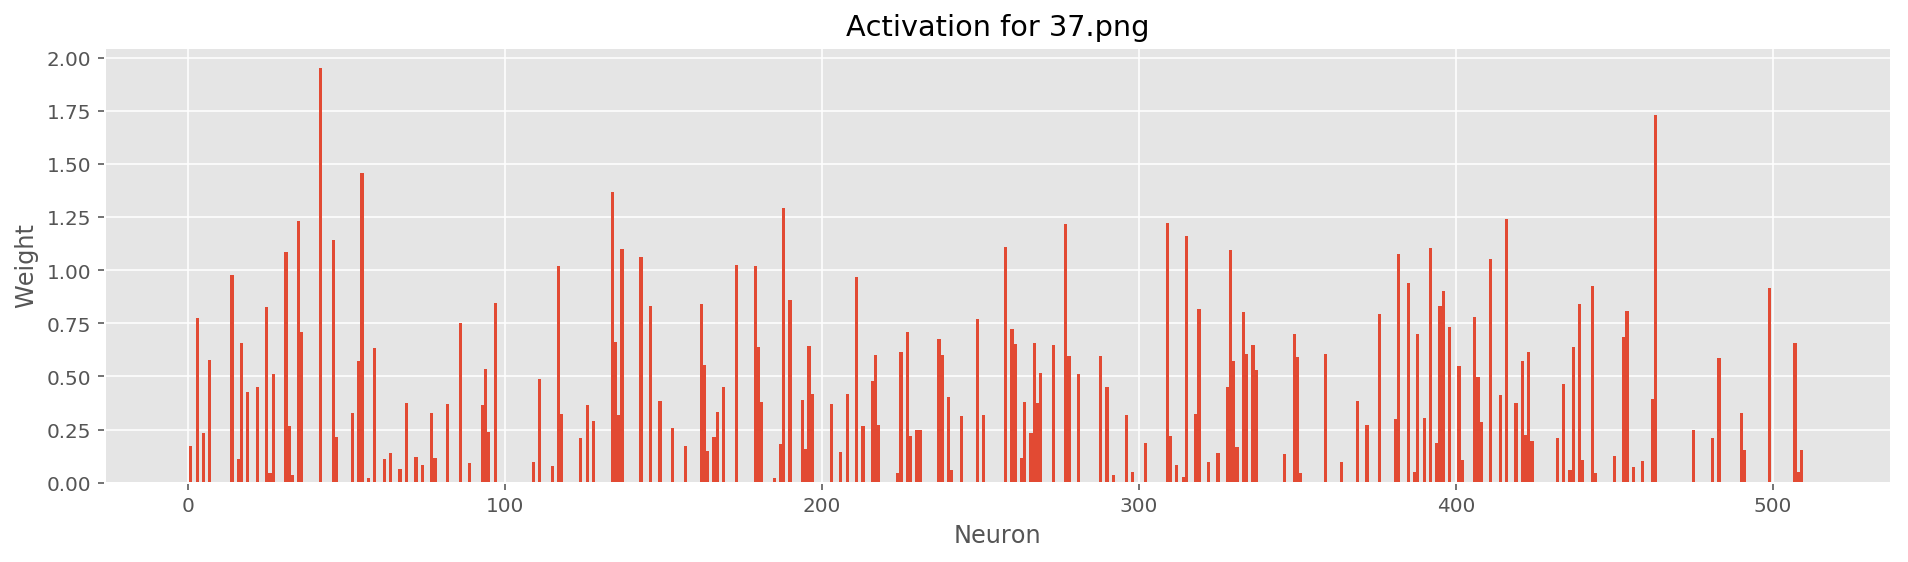

In [153]:
plt.figure(figsize=(16,4))
plt.bar(np.arange(512), get_activations(model, validation_filepaths[11]), width=1)
plt.title('Activation for {}'.format(
    os.path.split(validation_filepaths[11])[-1]))
plt.xlabel('Neuron')
plt.ylabel('Weight')

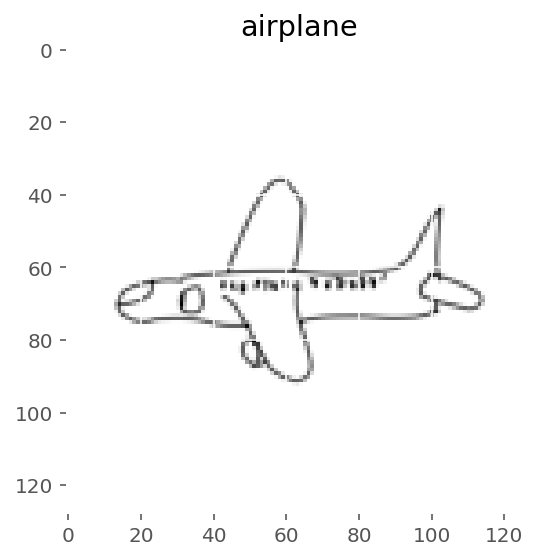

In [121]:
plot_image(categories, validation_filepaths, labels, 11)

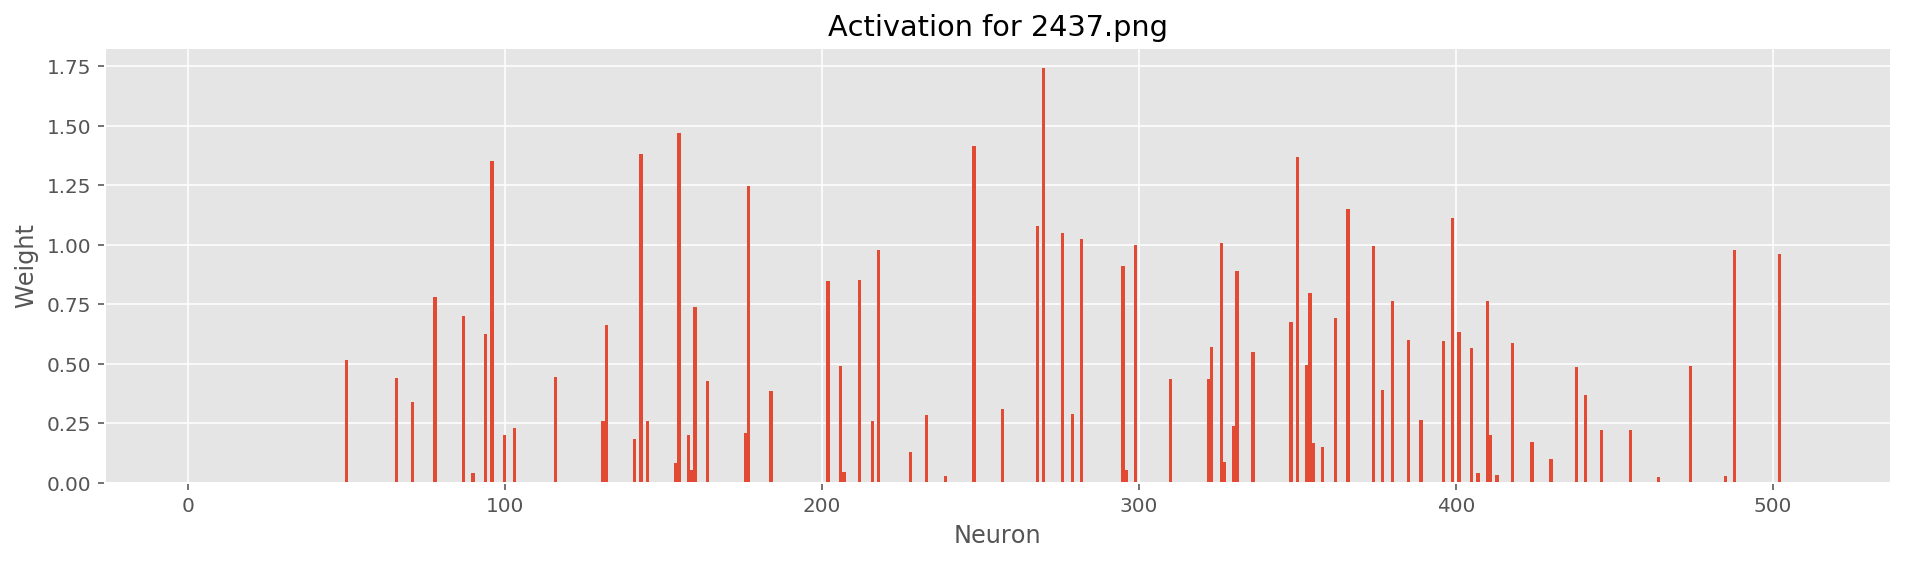

In [152]:
plt.figure(figsize=(16,4))
plt.bar(np.arange(512), get_activations(model, validation_filepaths[501]), width=1)
plt.title('Activation for {}'.format(
    os.path.split(validation_filepaths[501])[-1]))
plt.xlabel('Neuron')
plt.ylabel('Weight')

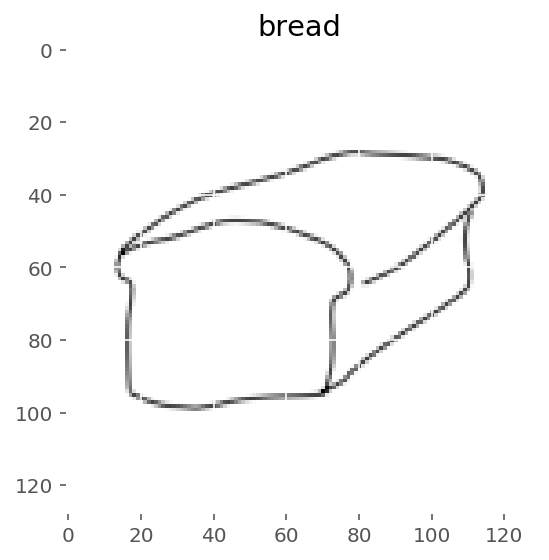

In [122]:
plot_image(categories, validation_filepaths, labels, 501)

### Calculate and compare the cosine distance between airplanes 10, 11, and 12 

In [113]:
def calc_cosine(a, b):
    from scipy.spatial.distance import cosine
    return cosine(a, b)

In [130]:
print(calc_cosine(
    get_activations(model, validation_filepaths[10]).tolist(), 
    get_activations(model, validation_filepaths[10]).tolist()))

0.0


In [131]:
print(calc_cosine(
    get_activations(model, validation_filepaths[10]).tolist(), 
    get_activations(model, validation_filepaths[11]).tolist()))

0.264798866125


In [132]:
print(calc_cosine(
    get_activations(model, validation_filepaths[10]).tolist(), 
    get_activations(model, validation_filepaths[12]).tolist()))

0.690074719232


In [135]:
print(calc_cosine(
    get_activations(model, validation_filepaths[10]).tolist(), 
    get_activations(model, validation_filepaths[10], flip=True).tolist()))

0.305935374146


## Create CoreML model 

In [144]:
import coremltools

In [208]:
coreml_model = coremltools.converters.keras.convert(model, 
                                                    input_names=['image'], 
                                                    image_input_names=['image'],
                                                    output_names=['classActivations'])

0 : input_convnet_1_16_7x7_input, <keras.engine.topology.InputLayer object at 0x134104390>
1 : input_convnet_1_16_7x7, <keras.layers.convolutional.Conv2D object at 0x1341d7ed0>
2 : input_convnet_1_16_7x7__activation__, <keras.layers.core.Activation object at 0x137197090>
3 : max_pooling2d_10, <keras.layers.pooling.MaxPooling2D object at 0x132755f90>
4 : convnet_2_32_5x5, <keras.layers.convolutional.Conv2D object at 0x1341d72d0>
5 : convnet_2_32_5x5__activation__, <keras.layers.core.Activation object at 0x134116750>
6 : max_pooling2d_11, <keras.layers.pooling.MaxPooling2D object at 0x1341d7250>
7 : convnet_3_64_3x3, <keras.layers.convolutional.Conv2D object at 0x1371c00d0>
8 : convnet_3_64_3x3__activation__, <keras.layers.core.Activation object at 0x134116d50>
9 : max_pooling2d_12, <keras.layers.pooling.MaxPooling2D object at 0x132b35950>
10 : flatten_4, <keras.layers.core.Flatten object at 0x132b27e50>
11 : dense_1_1024, <keras.layers.core.Dense object at 0x132b62910>
12 : dense_1_1024

In [209]:
coreml_model.input_description

Features(image)

In [210]:
coreml_model.output_description

Features(classActivations)

In [211]:
coreml_model.author = 'Joshua Newnham'
coreml_model.license = 'BSD'
coreml_model.short_description = 'Based on the freehand sketch recognizer, trained using the dataset from the paper How Do Humans Sketch Objects? consisting of 250 categories using a total of 20k examples, but instead of classifying this model returns the activations of the last layer for visual similarity matching'
coreml_model.input_description['image'] = 'Input sketch (grayscale image) to be processed'
coreml_model.output_description['classActivations'] = 'Activations for a given image'

In [212]:
coreml_model.save('output/cnnsketchfeatureextractor.mlmodel')